## Importing the libraries

In [1]:
# Libraries for visualization
import plotly as py
from plotly.offline import plot, iplot
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)
import matplotlib.pyplot as plt

# Libraries for data reading and handling
from datetime import datetime
import pandas
import numpy as np

# Libraries for neural net trainingand evaluation
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import math

# Library for generating the random numbers
import random
from operator import itemgetter

# hidding the warnings
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, Markdown

In [2]:
# Checking the tensorflow version
tf.__version__

'1.13.1'

## Functions for reading in the data and removing the outliers

In [3]:
"""
Reads in the 50 scenes in to the memory and then slices the data frame to achieve optimization
Takes 1.72 sec to read the 50 scenes file into memory
Slicing each scene takes 0.32 milli seconds on average
"""
def read_file(file_path):

    giant_df = pandas.read_csv(file_path, usecols=[1,2,3,4], names=["lz","X","Y","Z"])
    num_of_scenes = len(giant_df)/72000
    dataframes = []

    for i in range(int(num_of_scenes)):
        start = i*72000
        end = start+72000
        dataframes.append(giant_df.iloc[start:end,:])

    return dataframes

In [4]:
"""
Takes 0.36 sec to remove the outliers in each scene
"""

# Function to remove outliers
def remove_outliers(dataframes, number_of_scenes, path_to_pkl):
    object_points = []
    outliers = pandas.read_pickle(path_to_pkl)
    max_rad = []
    min_rad = []
    for i in range(64):
        max_rad.append(outliers[outliers['lz']==i]['max'].tolist()[0])
        min_rad.append(outliers[outliers['lz']==i]['min'].tolist()[0])

    for i in range(number_of_scenes):
        df = dataframes[i]
        df['radius'] = df.X.pow(2).add(df.Y.pow(2).add(df.Z.pow(2))).pow(0.5).round(1)
        df.drop(df[df['radius']==0].index, inplace=True)
        temp_out = pandas.DataFrame()
        for j in range(64):
            dummy_df = df[df['lz']==j]
            bool_vec = ~((dummy_df['radius']<=max_rad[j]) & (dummy_df['radius']>=min_rad[j]))
            temp_out = temp_out.append(dummy_df[bool_vec])
        object_points.append(temp_out)

    return object_points

## Function for visualizing the data

In [5]:
def visualize(object_data_frame, view, x_range = [-30,30],y_range=[-120,120], use_distance=False):
    x = tuple(object_data_frame['X'].tolist())
    y = tuple(object_data_frame['Y'].tolist())
    z = tuple(object_data_frame['Z'].tolist())
    if use_distance:
        radius = tuple(object_data_frame['radius'].tolist())
    else:
        radius = 'red'
    if view==1:
        x_points = x
        y_points = z
    elif view==2:
        x_points = x
        y_points = y
    elif view==3:
        x_points = z
        y_points = y
    else:
        print("Not a valid view")
        x_points = x
        y_points = z
    trace = go.Scatter(
            x = x_points,
            y = y_points,
            mode = 'markers',
            marker = dict(
                        color=radius,
                        size = 2,
                        opacity = 1)
            )
    layout = go.Layout(
                    scene = dict(
                    
                    xaxis = dict(
                        range = x_range
                        ),
                    yaxis = dict(
                        range = y_range
                        )
                    )
                )
    
    data = [trace]
    fig = go.Figure(data=data,layout = layout)
    iplot(fig)

## Path variables and objects

In [6]:
# objects
object_names = {0: 'Atm', 1: 'Bench', 2: 'BigSassafras', 3: 'BmwX5Simple', \
                4: 'ClothRecyclingContainer', 5: 'Cypress', 6: 'DrinkingFountain',\
                7: 'ElectricalCabinet', 8: 'EmergencyPhone', 9: 'FireHydrant',\
                10: 'GlassRecyclingContainer', 11: 'IceFreezerContainer', 12: 'Mailbox',\
                13: 'MetallicTrash', 14: 'MotorbikeSimple', 15: 'Oak', 16: 'OldBench',\
                17: 'Pedestrian', 18: 'PhoneBooth', 19: 'PublicBin', 20: 'Sassafras',\
                21: 'ScooterSimple', 22: 'set1', 23: 'ToyotaPriusSimple', 24: 'Tractor',\
                25: 'TrashBin', 26: 'TrashContainer', 27: 'UndergroundContainer',\
                28: 'WorkTrashContainer'}

In [7]:
# Select the objects from above
user_choice = 23

# Path to dataset in file
folder_path = "/home/samba693/DataChallenge/debs2019_initial_dataset"
file_path = "{}/{}/in.csv".format(folder_path, object_names[user_choice])

# number of scenes to read in must be less than or equal to 50
num_of_scenes = 50

# Path to the outliers pkl file
outliers_path = "../object-net/outliers.pkl"

# 2-D image length and height
img_length = 10
img_height = 7

## Function to visualize desired number of scenes in animation

In [8]:
#### Not so import to look at #####
"""
This function creates the visualization of the object points in particular view for given num_of_scenes

"""
def visualize_50_html(num_of_scenes, view, objects, object_name = object_names[user_choice]):

    # Creating the list of scenes
    scenes = range(num_of_scenes)

    # make figure
    figure = {
        'data': [],
        'layout': {},
        'frames': []
    }

    # fill in most of layout
    figure['layout']['xaxis'] = {'range': [-120, 120], 'title': 'x-axis'}
    figure['layout']['yaxis'] = {'title': 'y-axis'}
    figure['layout']['hovermode'] = 'closest'
    figure['layout']['sliders'] = {
        'args': [
            'transition', {
                'duration': 400,
                'easing': 'cubic-in-out'
            }
        ],
        'initialValue': '0',
        'plotlycommand': 'animate',
        'values': scenes,
        'visible': True
    }
    figure['layout']['updatemenus'] = [
        {
            'buttons': [
                {
                    'args': [None, {'frame': {'duration': 500, 'redraw': False},
                             'fromcurrent': True, 'transition': {'duration': 300, 'easing': 'quadratic-in-out'}}],
                    'label': 'Play',
                    'method': 'animate'
                },
                {
                    'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate',
                    'transition': {'duration': 0}}],
                    'label': 'Pause',
                    'method': 'animate'
                }
            ],
            'direction': 'left',
            'pad': {'r': 10, 't': 87},
            'showactive': False,
            'type': 'buttons',
            'x': 0.1,
            'xanchor': 'right',
            'y': 0,
            'yanchor': 'top'
        }
    ]

    sliders_dict = {
        'active': 0,
        'yanchor': 'top',
        'xanchor': 'left',
        'currentvalue': {
            'font': {'size': 20},
            'prefix': 'Scene:',
            'visible': True,
            'xanchor': 'right'
        },
        'transition': {'duration': 300, 'easing': 'cubic-in-out'},
        'pad': {'b': 10, 't': 50},
        'len': 0.9,
        'x': 0.1,
        'y': 0,
        'steps': []
    }

    # make data
    scene = 0

    object_by_scene = objects[scene]
    x = tuple(object_by_scene['X'].tolist())
    y = tuple(object_by_scene['Y'].tolist())
    z = tuple(object_by_scene['Z'].tolist())
    radius = tuple(object_by_scene['radius'].tolist())
    if view==1:
        x_points = x
        y_points = z
    
    elif view==2:
        x_points = x
        y_points = y

    elif view==3:
        x_points = z
        y_points = y
    
    else:
        print("Not a valid view")
        x_points = x
        y_points = z
        
    data_dict = {
        'x': x_points,
        'y': y_points,
        'mode': 'markers',
        'marker': {
                'color':radius,
                'size': 2,
                'opacity':1        
        }
    }
    figure['data'].append(data_dict)

    
    # make frames
    for scene in scenes:
        frame = {'data': [], 'name': str(scene)}

        object_by_scene = objects[scene]
        x = tuple(object_by_scene['X'].tolist())
        y = tuple(object_by_scene['Y'].tolist())
        z = tuple(object_by_scene['Z'].tolist())
        radius = tuple(object_by_scene['radius'].tolist())
        if view==1:
            x_points = x
            y_points = z
        elif view==2:
            x_points = x
            y_points = y
        elif view==3:
            x_points = z
            y_points = y
        else:
            print("Not a valid view")
            x_points = x
            y_points = z

        data_dict = {
            'x': x_points,
            'y': y_points,
            'mode': 'markers',
            'marker': {
                    'color':radius,
                    'size': 2,
                    'opacity':1        
            }
        }
        frame['data'].append(data_dict)

        figure['frames'].append(frame)
        
        slider_step = {'args': [
            [scene],
            {'frame': {'duration': 300, 'redraw': False},
             'mode': 'immediate',
           'transition': {'duration': 300}}
         ],
         'label': scene,
         'method': 'animate'}
        sliders_dict['steps'].append(slider_step)


    figure['layout']['sliders'] = [sliders_dict]

    plot(figure, filename = "../visuals/{}_{}_{}.html".format(object_name, num_of_scenes, view),auto_open=False, show_link = False)

## Creating the list of scenes

In [9]:
dataframes = read_file(file_path)

## removing the outliers and creating the list of object points

In [10]:
objects = remove_outliers(dataframes, num_of_scenes, outliers_path )

## Plotting the object points in the desire view

View | Number
---------- | -----------
XZ | 1
XY | 2
ZY | 3

In [11]:
# Select only the desired scene and desired angle
scene_to_plot = objects[6]
view = 3

# plotting the object with desired view
visualize(scene_to_plot, view)

In [12]:
# Creating the animation 
# The animation is created as a html file at src/visual/objectName_{num_of_scenes}_{view}
visualize_50_html(num_of_scenes=50,view=3, objects=objects)

## Function to get only the object points with the help of clustering

In [13]:
"""
Helper function to just return the object points by removing the 
"""
def helper_object_points(object_points, num_clusters):
    
    # cluster the points and get the labels
    kmeans_model = KMeans(n_clusters=num_clusters, random_state=1).fit(object_points)
    object_points['labels'] = kmeans_model.labels_
    
    # use the labels to slice the points and return the object points
    object_points = object_points[object_points['labels']==object_points.labels.mode()[0]]
    return object_points

## Function for returning the x_max and x_min for every object

In [14]:
"""
This function fits the points into the constant scale by calculating the x_max, x_min and y_max and y_min
This works only for XY view or ZY view
"""
def max_min(obj_data, img_length, img_height, view):
    # Lists to return which will help in plotting and collecting the data with in this range for the CNN
    x_max = []
    x_min = []
    y_max = []
    y_min = []
    
    ## going through each scene
    for i in obj_data:
            
#         # calculate the y_max and min and then compare with the img_height and add the required height
#         y_maximum = i['Y'].max()
#         y_minimum = i['Y'].min()
#         range_y = y_maximum-y_minimum
#         first,second = generate_random(img_height -range_y)
        
        #using the mean to calculate the y_max and y_min
        y_mean = i['Y'].mean()
        first,second = generate_random(img_height)
        
        # Appending the max and min values
        y_max.append(y_mean+first)
        y_min.append(y_mean-second)
        
#         # Appending the max and min values
#         y_max.append(y_maximum+first)
#         y_min.append(y_minimum-second)
        
        
        
        # if the view is XY calcualte for X
        if view==2:
#             x_maximum = i['X'].max()
#             x_minimum = i['X'].min()
#             range_x = x_maximum-x_minimum
#             first,second = generate_random(img_length -range_x)

#             # Appending the max and min values
#             x_max.append(x_maximum+first)
#             x_min.append(x_minimum-second)
            
            #using the mean to calculate the y_max and y_min
            x_mean = i['X'].mean()
            first,second = generate_random(img_length)

            # Appending the max and min values
            x_max.append(x_mean+first)
            x_min.append(x_mean-second)
        
        # if the view is for ZY calcuate for Z
        elif view==3:
#             z_maximum = i['Z'].max()
#             z_minimum = i['Z'].min()
#             range_x = z_maximum-z_minimum
#             first,second = generate_random(img_length -range_x)

#             # Appending the max and min values
#             x_max.append(z_maximum+first)
#             x_min.append(z_minimum-second)       
            
            #using the mean to calculate the y_max and y_min
            z_mean = i['Z'].mean()
            first,second = generate_random(img_length)

            # Appending the max and min values
            x_max.append(z_mean+first)
            x_min.append(z_mean-second)
    
    return (x_max,x_min,y_max,y_min) 

In [15]:
"""
Helper function for max_min to generate random numbers
"""
def generate_random(residual):
    if residual<0:
        return 0,0
    first = random.randint(1,20)
    sec = random.randint(1,20)
    tot = float(first+sec)
    return (first*residual/tot, sec*residual/tot)

## Collecting the image range values for the respective view

In [16]:
# change the view here
needed_view = 3


#Call the helper function to only get the object points
new_objects = []
num_clusters = 4

for i in objects:
    i = helper_object_points(i, num_clusters)
    new_objects.append(i)

# new_objects = objects

# calling the function for the range values
x_max, x_min, y_max, y_min = max_min(new_objects, img_length, img_height, needed_view)

# checking the range values
print("Image length = {}".format(img_length))
print(np.array(x_max)-np.array(x_min))  
print("Image height = {}".format(img_height))
print(np.array(y_max)-np.array(y_min))

Image length = 10
[10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
Image height = 7
[7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7.
 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7.
 7. 7.]


## Plotting the images using this range

In [17]:
# select the image of choice between 0 to 49
img_choice = 34

# selecting the range values
x_range = [x_min[img_choice] , x_max[img_choice]]
y_range = [y_min[img_choice] , y_max[img_choice]]

# the scene to plot
scene_to_view = new_objects[img_choice]

# plotting the graph with the given range and if you want to change the view change the needed_view variable
visualize(scene_to_view, needed_view, x_range, y_range)

## Function for Plotting the figure in grid

In [18]:
"""
Function to plot the given object points in the given view with grid
"""

def plot_grid(object_points,grid_size,view, x_range,y_range):
    
    # plots only for two views
    y = tuple(object_points['Y'].tolist())
    
    if view==2:
        x = tuple(object_points['X'].tolist())
    elif view==3:
        x = tuple(object_points['Z'].tolist())
        
    # Plotting the figure
    fig = plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
    ax = fig.gca()
    ax.set_xticks(np.arange(x_range[0], x_range[1], grid_size))
    ax.set_yticks(np.arange(y_range[0], y_range[1], grid_size))
    plt.scatter(x, y, s=4)
    plt.xlim(x_range[0], x_range[1])
    plt.ylim(y_range[0], y_range[1])
    plt.grid()
    plt.show()

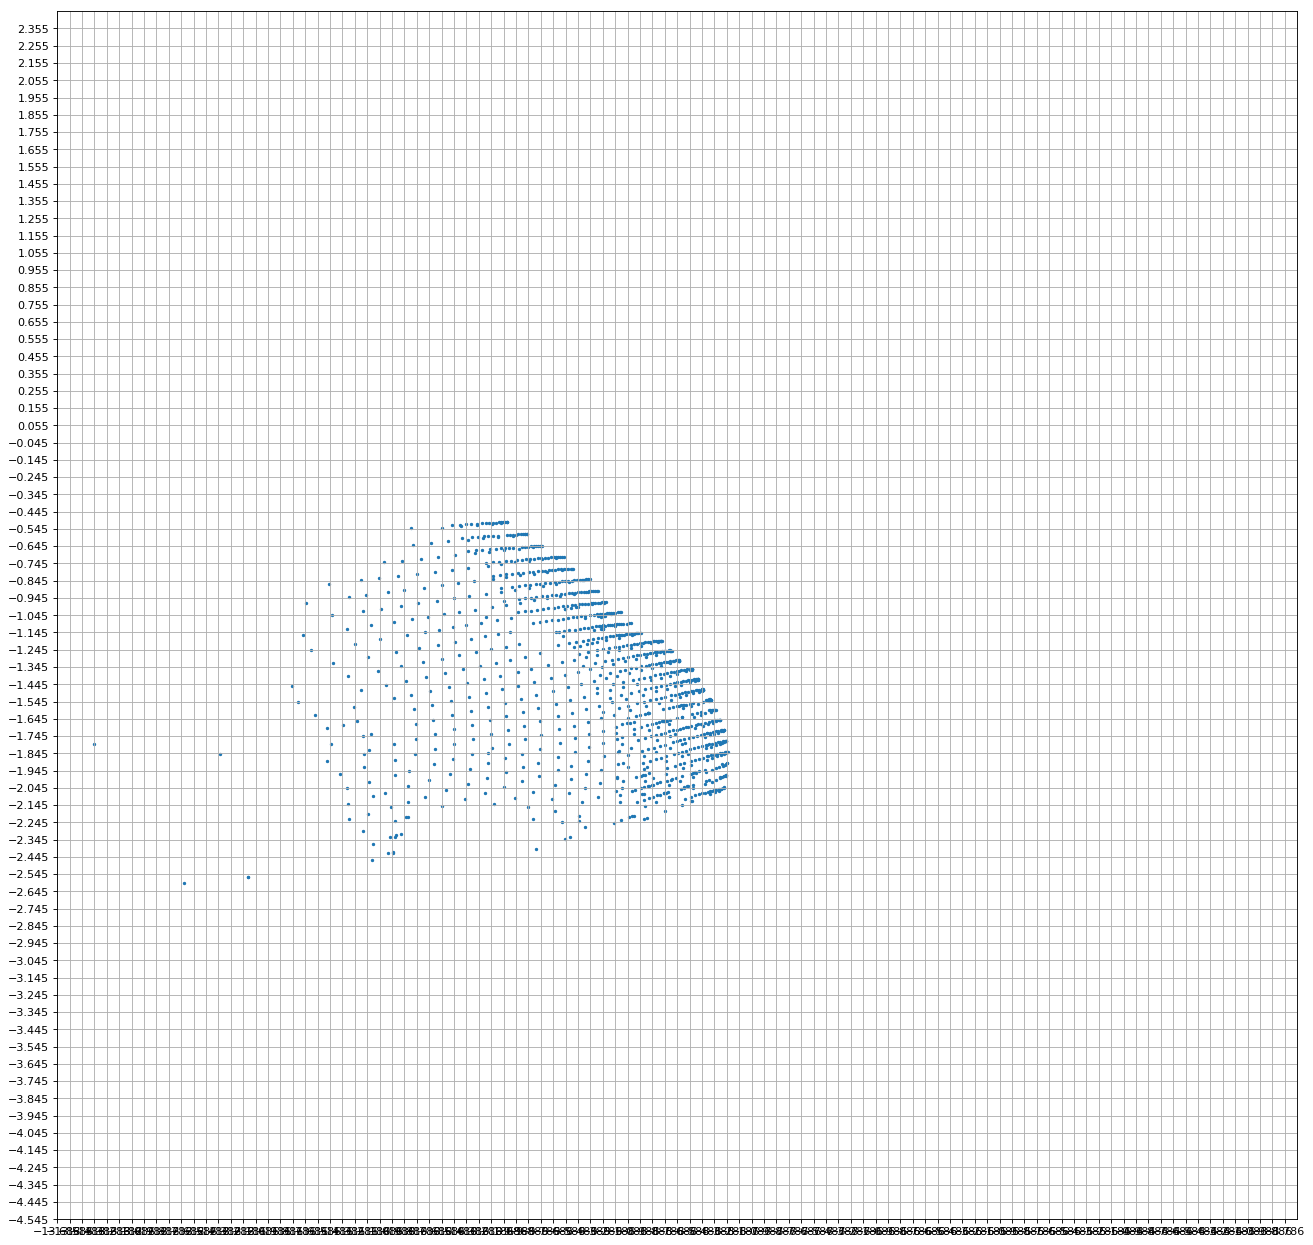

In [19]:
"""
Variables used in this cell are above, view, scene_to_view and img_choice
"""
# Variable for the gid size
grid_size = 0.1

# graph
plot_grid(scene_to_view, grid_size, view, x_range, y_range)

## Function to create the input to CNN

In [20]:
"""
    - Function to create the input to the cnn function, need to see the time and optimize it later
"""

def input_nn(object_points, x_range, y_range, grid_size, img_length, img_height, view):
    # Need to check the time
    start_time = datetime.now()
    
    # create an empty numpy array for the counts
    n_rows = int(img_height/grid_size)
    n_cols = int(img_length/ grid_size)
    
    input_list = np.zeros((n_rows, n_cols))
    
    # Populate the input array
    gridx = np.linspace(x_range[0],x_range[1],n_cols+1)
    gridy = np.linspace(y_range[0],y_range[1],n_rows+1)
    
    # according to the view
    if view==2:
        x = np.array(object_points['X'])
    elif view==3:
        x = np.array(object_points['Z'])
    
    y = np.array(object_points['Y'])
    
    grid, _, _ = np.histogram2d(x,y,bins=[gridx,gridy])
    
    print("Time taken = {}".format(datetime.now()-start_time))
    
    # Returning the input
    return np.rot90(grid)

Time taken = 0:00:00.002022


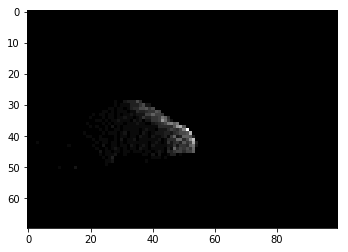

In [21]:
# calling the function to get the input for the neural net to train
input_arr = input_nn(scene_to_view, x_range, y_range, grid_size, img_length, img_height, view)

# plotting the image
plt.imshow(input_arr, cmap="gray")

## Function to transform the data to desired angle

In [22]:
"""
Function to transform the data to the given angle only works for the 
"""
# ToDo: write a function for the transformation about x - z axis
def transform_angle(object_points, angle):
    pass

## Function for preparing the input for the desired object and saving the data

In [23]:
"""
    Function for preparing the input for the desired object with linear transformations 
    and two different views.
    
    Extend to get the training data from different angles
"""

def prepare_and_save_input(object_choice, object_names, folder_path, num_linear_transformations,\
                           num_of_scenes, path_to_pkl, grid_size,\
                           num_of_clusters, img_length, img_height,\
                           list_of_angles=[30, 60, 90, 120, 150]):
    
    # Creating the path for the object
    object_path = "{}/{}/in.csv".format(folder_path, object_names[object_choice])
    
    # read in the object of choice
    dataframes = read_file(object_path)
    
    # remove the outliers
    no_outliers = remove_outliers(dataframes, num_of_scenes, path_to_pkl)
    
    # get the object points
    new_objects = []
    
    for i in no_outliers:
        new_objects.append(helper_object_points(i,num_of_clusters))
    
    # scale the points
    x_max_x ,x_min_x , y_max_x , y_min_x = max_min(new_objects, img_length, img_height, 2)
    x_max_z ,x_min_z , y_max_z , y_min_z = max_min(new_objects, img_length, img_height, 3)
    
    # get the input for each scene with 4 different linear transformations
    n = len(new_objects)
    
    input_data = []
    output = []
    
    for i in range(n):
        
        # get the objects with various number of linear transformations
        for j in range(num_linear_transformations):
            
            # creating the input in the XY view
            input_data.append(input_nn(new_objects[i],[x_min_x[i], x_max_x[i]],\
                                   [y_min_x[i],y_max_x[i]], grid_size, img_length, img_height, 2))
            output.append(object_names[object_choice])
            
            # Creating the input for the ZY view
            input_data.append(input_nn(new_objects[i],[x_min_z[i], x_max_z[i]],\
                                   [y_min_z[i],y_max_z[i]], grid_size, img_length, img_height, 3))
            output.append(object_names[object_choice])                              
            
    # Save the objects
    np.save('../data/{}_input.npy'.format(object_names[object_choice]), input_data)
    np.save('../data/{}_output.npy'.format(object_names[object_choice]), output)

## Creating the data

In [24]:
# list of individual objects
list_of_object_choice = list(range(29))
list_of_object_choice.remove(22)

In [25]:
# # required variables
# num_linear_transformations = 4
# num_of_scenes = 50
# path_to_pkl = "../object-net/outliers.pkl"
# grid_size = 0.1
# num_clusters = 4
# img_length = 10
# img_height = 7

# # Calling the function
# for i in list_of_object_choice:
#     prepare_and_save_input(i, object_names, folder_path, num_linear_transformations,\
#                           num_of_scenes, path_to_pkl, grid_size,\
#                           num_clusters, img_length, img_height)

## Plotting the input of objects for testing purposes

In [26]:
# reading in the data of the desired object
# for j in list_of_object_choice:
#     desired_object = j
#     file_name = "../data/{}_input.npy".format(object_names[desired_object])
#     to_plot = np.load(file_name)


#     # plotting the object
#     fig = plt.figure(figsize=(100,100))
#     colums = 20
#     rows = 20
#     count = 1

#     for i in to_plot:    
#         fig.add_subplot(rows, colums, count)
#         count+=1
#         plt.imshow(i)

#     plt.savefig("../visuals/{}.png".format(object_names[desired_object]))
#     plt.clf()

## Prepare the training and testing data

### Select the objects to train and test

```
{0: 'Atm', 1: 'Bench', 2: 'BigSassafras', 3: 'BmwX5Simple', \
    4: 'ClothRecyclingContainer', 5: 'Cypress', 6: 'DrinkingFountain',\
    7: 'ElectricalCabinet', 8: 'EmergencyPhone', 9: 'FireHydrant',\
    10: 'GlassRecyclingContainer', 11: 'IceFreezerContainer', 12: 'Mailbox',\
    13: 'MetallicTrash', 14: 'MotorbikeSimple', 15: 'Oak', 16: 'OldBench',\
    17: 'Pedestrian', 18: 'PhoneBooth', 19: 'PublicBin', 20: 'Sassafras',\
    21: 'ScooterSimple', 22: 'set1', 23: 'ToyotaPriusSimple', 24: 'Tractor',\
    25: 'TrashBin', 26: 'TrashContainer', 27: 'UndergroundContainer',\
    28: 'WorkTrashContainer'}
```

### Helper function for creating the training and test data

In [27]:
"""
    Function that creates the train and test split
"""
def train_test_split(object_id):
    
    # Input file and output file names
    file_name = "../data/{}_input.npy".format(object_names[object_id])
    output_file = "../data/{}_output.npy".format(object_names[object_id])
    
    # loading the saved npy format data
    object_input = np.load(file_name)
    object_output = np.load(output_file)
    
    # Creating the random shuffle data
    c = list(range(len(object_input)))
    
    # use random.Random(4) for fixing the seed
    random.shuffle(c)
    
    num_of_train = int(round(0.7*len(c)))
    train = c[:num_of_train]
    test = c[num_of_train:]
    
    # Collecting the items of this index into 
    train_input = list(itemgetter(*train)(object_input))
    test_input = list(itemgetter(*test)(object_input))
    train_output = list(itemgetter(*train)(object_output))
    test_output = list(itemgetter(*test)(object_output))
    
    # Adding them to the previous lists
    return train_input, test_input, train_output, test_output

In [28]:
# list of objects
include_objects = list_of_object_choice

# load the data and append all the data into a single list both input and output data
input_train = []
input_test = []
output_train = []
output_test = []

for i in include_objects:
    # calling the function
    a,b,c,d = train_test_split(i)
    
    # adding them to the exsisting lists
    input_train += a
    input_test += b
    output_train += c
    output_test += d

In [29]:
# printing the number of training samples and their shapes
print("Size of:")
print("- Training-set:\t\t{}".format(len(input_train)))
print("- Test-set:\t\t{}".format(len(input_test)))

Size of:
- Training-set:		7840
- Test-set:		3360


### Transforming the data according to the neural net

In [30]:
"""
    Converting the input arr into flat array and return the flattened input array for training
"""
def flat_input(input_arr):
    # Reshape each numpy array in the list
    to_return = []
    for i in input_arr:
        to_return.append(i.flatten())
    return np.array(to_return)
    
"""
    Encodes the output arr to one hot encoding and return the encoders and encoded values
"""
def encode_output(output_arr):
    # Transforming the output to one hot encoding, buy using label encoder at first and then one hot encoder
    encoder = LabelEncoder()
    encoded_out_test = encoder.fit_transform(output_arr)

    # using one hot encoder
    encoder1 = OneHotEncoder()
    encoded_out_test = encoder1.fit_transform(encoded_out_test.reshape(-1,1)).toarray()
    
    # returning the encoders and encoded values
    return encoded_out_test, encoder, encoder1

In [31]:
# Encoding and flattening the training data
train_out_encode, encoder, encoder1 = encode_output(output_train)
train_input_encode = flat_input(input_train)

# Encoding and Flattening the test data
test_out_encode, encoder2, encoder3 = encode_output(output_test)
test_input_encode = flat_input(input_test)

### Dimensions of the data

In [32]:
# Storing the images in one dimensional arraays of the length
img_size_flat = input_train[0].shape[0]*input_train[0].shape[1]

# Height and width of the image
img_shape = input_train[0].shape

# Number of classes
num_classes = len(include_objects)

# Number of color channels: 1 for grayscale
num_channels = 1

## Construct a CNN

In [33]:
# Convolution Layer 1
filter_size1 = 5           # convolution filters are 5x5.
num_filters1 = 16         # There are 16 filters.

# Convolution Layer 2
filter_size2 = 5
num_filters2 = 16

# fully_connected Layer
fc_size = 128

### Helper function for creating weights and biases

In [34]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [35]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

### Helper-function for creating a new convolutional layer

In [36]:
def new_conv_layer(input_layer,
                  num_input_channels,
                  filter_size,
                  num_filters,
                  use_pooling=True):
    
    # Shape of the filter-weights for the convolution
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    
    # Create new weights with the shape
    weights = new_weights(shape=shape)
    
    # create the new biases of each filter
    biases = new_biases(length=num_filters)
    
    # creating the layer
    layer = tf.nn.conv2d(input=input_layer,
                        filter=weights,
                        strides=[1,1,1,1],
                        padding='SAME')
    
    # adding the bias to the layer
    layer += biases
    
    # Create the max pooling layer
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                              ksize=[1,2,2,1],
                              strides=[1,2,2,1],
                              padding='SAME')
    # Adding relu
    layer = tf.nn.relu(layer)
    
    # return the layer and weights. Weights are used to plot the weights later
    return layer, weights

### Helper function for flattening a layer

In [37]:
def flatten_layer(layer):
    # get the shape of the input layer.
    layer_shape = layer.get_shape()
    
    # The shape of the input layer is assusmed to be
    # layer_shape == [num_images, img_height, img_width, num_channels]
    
    # The number of features is: img_height* img_width * num_of channels
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features]
    layer_flat = tf.reshape(layer, [-1, num_features])
    
    # returning the flattened layer
    return layer_flat, num_features

###  Helper function for creating a new fully connected layer

In [38]:
def new_fc_layer(input_layer,
                num_inputs,
                num_outputs,
                use_relu = True):
    
    # create new weights and biases
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    
    # calculating the layer
    layer = tf.matmul(input_layer, weights) + biases
    
    # check if is relu
    if use_relu:
        layer = tf.nn.relu(layer)
    
    return layer

### Placeholder variables

In [39]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

In [40]:
x_image = tf.reshape(x,[-1, img_shape[0], img_shape[1], num_channels])

In [41]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

In [42]:
y_true_cls = tf.argmax(y_true, axis=1)

### Convolution Layer 1

In [43]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input_layer= x_image,
                  num_input_channels=num_channels,
                  filter_size = filter_size1,
                  num_filters = num_filters1,
                  use_pooling=True)

Instructions for updating:
Colocations handled automatically by placer.


In [44]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 35, 50, 16) dtype=float32>

### Convolution Layer 2

In [45]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input_layer=layer_conv1,
                  num_input_channels=num_filters1,
                  filter_size = filter_size2,
                  num_filters= num_filters2,
                   use_pooling=True)

In [46]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 18, 25, 16) dtype=float32>

###  Flatten layer

In [47]:
layer_flat, num_features = flatten_layer(layer_conv2)

In [48]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 7200) dtype=float32>

In [49]:
num_features

7200

### Fully-Connected Layer 1

In [50]:
layer_fc1 = new_fc_layer(input_layer=layer_flat,
                        num_inputs= num_features,
                        num_outputs= fc_size,
                        use_relu=True)

In [51]:
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

### Fully-Connected Layer 2

In [52]:
layer_fc2 = new_fc_layer(input_layer=layer_fc1,
                        num_inputs = fc_size,
                        num_outputs= num_classes,
                        use_relu= False)

In [53]:
layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 28) dtype=float32>

### Predicted Class

In [54]:
y_pred = tf.nn.softmax(layer_fc2)

In [55]:
y_pred_cls = tf.argmax(y_pred, axis=1)

### Cost-Function to be optimized

In [56]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                       labels=y_true)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [57]:
cost = tf.reduce_mean(cross_entropy)

### Optimization Method

In [58]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

### Performance Measures

In [59]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [60]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Train the model

### Create the tensorflow session

In [61]:
session = tf.Session()

### Initialize the variables

In [62]:
session.run(tf.global_variables_initializer())

### Helper function to perform the optimization iterations

In [63]:
train_batch_size = 32

### Helper function for creating the batches

In [64]:
def random_batch(input_train, output_train, batch_size):
    # zipping the input and output
    zipped_data = list(zip(input_train, output_train))
    
    # Shuffle them
    random.shuffle(zipped_data)
    
    # select the elements equal to batch_size
    zipped_data = zipped_data[:batch_size]
    
    # unzip the elements
    to_return = list(zip(*zipped_data))
    x_batch = np.array(to_return[0],dtype=np.float32)
    y_batch = np.array(to_return[1],dtype=np.float32)
    
    # return the elements 
    return x_batch, y_batch

In [65]:
# Counter for the total number of iterations performed so far
total_iterations = 0

def optimize(num_iterations, train_batch_size, input_train, output_train):
    
    global total_iterations
    
    # Start time
    start_time = datetime.now()
    
    for i in range(total_iterations, total_iterations+num_iterations):
        
        # get the batch of the training examples
        x_batch, y_true_batch = random_batch(input_train, output_train, batch_size=train_batch_size)
        
        # Put the batch in the dict with the proper names
        feed_dict_train = {x:x_batch,
                          y_true: y_true_batch}
        
        # Run the optimizer using this batch of the training data
        session.run(optimizer, feed_dict= feed_dict_train)
        
        # printing status for every 10 iterations
        if i%100 ==0:
            
            # Calculate the accuracy on the training set
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            print("Optimization Iteration: {0:>6}, Training Accuracy: {1:6.1%}".format(i+1,acc))
        
    # updating the total number of iterations performed
    total_iterations += num_iterations
        
    # Ending time
    end_time = datetime.now()

    print("Time usage: {}".format(end_time-start_time))        

## Test the model

### Function to plot Confusion matrix

In [66]:
def plot_confusion_matrix(cls_pred, cls_true):
    
    # get the confusion matrix using sklearn
    cm = confusion_matrix(y_true=cls_true,
                         y_pred = cls_pred)
    
    # Printing the confusion matrix as text
    print(cm)
    
    # plot the confusion matrix as image
    plt.matshow(cm)
    
    plt.colorbar()
    tick_marks= np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.show()

### Function for testing

In [67]:
test_batch_size = 64

def print_test_accuracy(test_input, test_output, show_confusion_matrix=False):
    
    # number of images in the test -set
    num_test = len(test_input)
    
    
    # creating an empty array
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    
    # Starting index
    i = 0
    
    while i<num_test:
        # J is the ending index
        j = min(i+test_batch_size, num_test)
        
        # get the images
        images = test_input[i:j]
        
        # Get the assiciated labels
        labels = test_output[i:j]
        
        # Feed the dict with the images and labels
        feed_dict = {x:images,
                    y_true: labels}
        
        # Calculate the predicated class using TensorFlow
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        
        i = j
    
    cls_true = [np.argmax(i) for i in test_output]
    cls_true = np.array(cls_true)
    
    correct = (cls_true==cls_pred)
    correct_sum = correct.sum()
    
    acc = float(correct_sum) / num_test
    
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    
    print(msg.format(acc, correct_sum, num_test))

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred, cls_true)

### Performance after 1 optimization iteration

In [68]:
# optimize(1, train_batch_size, train_input_encode, train_out_encode)

Accuracy on Test-Set: 3.4% (114 / 3360)
Confusion Matrix:
[[  0   0   5   0   3   1   0  11   0   0  52   0   0  32   0   2   0   0
    0   0   0   0   0  12   0   2   0   0]
 [  0   0   0   0   0   5   1  17   0   0  66   0   0  18   3   1   0   0
    4   0   0   0   0   3   0   2   0   0]
 [  0   1  12   0   4   7   0  11   0   0  58   0   0  17   0   2   0   0
    3   0   0   0   0   5   0   0   0   0]
 [  0   0   0   0   2   2   0   9   0   0  66   0   0  23   0   9   0   0
    3   0   0   0   0   4   0   2   0   0]
 [  0   0   0   0   0   3   0   8   0   0  80   0   0  27   0   0   0   0
    0   0   0   0   0   2   0   0   0   0]
 [  0   4   1   0   2   2   0  15   0   0  51   0   0  33   0   4   0   0
    0   0   0   0   0   5   0   3   0   0]
 [  0   0   0   0   0   0   0   8   0   0  97   0   0  15   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   2  14   0   0  78   0   0  20   0   2   0   0
    0   0   0   0   0   3   0   1   0   0]
 [  1 

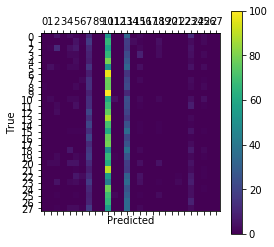

In [69]:
# Testing after 10 iterations
print_test_accuracy(test_input_encode,test_out_encode, True)

### Performance after 100 optimization iteration

In [70]:
# optimize(99, train_batch_size, train_input_encode, train_out_encode)

Accuracy on Test-Set: 3.4% (114 / 3360)
Confusion Matrix:
[[  0   0   5   0   3   1   0  11   0   0  52   0   0  32   0   2   0   0
    0   0   0   0   0  12   0   2   0   0]
 [  0   0   0   0   0   5   1  17   0   0  66   0   0  18   3   1   0   0
    4   0   0   0   0   3   0   2   0   0]
 [  0   1  12   0   4   7   0  11   0   0  58   0   0  17   0   2   0   0
    3   0   0   0   0   5   0   0   0   0]
 [  0   0   0   0   2   2   0   9   0   0  66   0   0  23   0   9   0   0
    3   0   0   0   0   4   0   2   0   0]
 [  0   0   0   0   0   3   0   8   0   0  80   0   0  27   0   0   0   0
    0   0   0   0   0   2   0   0   0   0]
 [  0   4   1   0   2   2   0  15   0   0  51   0   0  33   0   4   0   0
    0   0   0   0   0   5   0   3   0   0]
 [  0   0   0   0   0   0   0   8   0   0  97   0   0  15   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   2  14   0   0  78   0   0  20   0   2   0   0
    0   0   0   0   0   3   0   1   0   0]
 [  1 

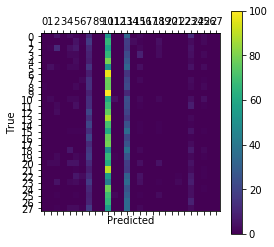

In [71]:
print_test_accuracy(test_input_encode,test_out_encode, True)

### Performance after 500 optimization iteration

In [72]:
# optimize(4000, train_batch_size, train_input_encode, train_out_encode)

In [73]:
display(Markdown("```Objects selected = {}```".format([object_names[i] for i in include_objects])))

```Objects selected = ['Atm', 'Bench', 'BigSassafras', 'BmwX5Simple', 'ClothRecyclingContainer', 'Cypress', 'DrinkingFountain', 'ElectricalCabinet', 'EmergencyPhone', 'FireHydrant', 'GlassRecyclingContainer', 'IceFreezerContainer', 'Mailbox', 'MetallicTrash', 'MotorbikeSimple', 'Oak', 'OldBench', 'Pedestrian', 'PhoneBooth', 'PublicBin', 'Sassafras', 'ScooterSimple', 'ToyotaPriusSimple', 'Tractor', 'TrashBin', 'TrashContainer', 'UndergroundContainer', 'WorkTrashContainer']```

Accuracy on Test-Set: 3.4% (114 / 3360)
Confusion Matrix:
[[  0   0   5   0   3   1   0  11   0   0  52   0   0  32   0   2   0   0
    0   0   0   0   0  12   0   2   0   0]
 [  0   0   0   0   0   5   1  17   0   0  66   0   0  18   3   1   0   0
    4   0   0   0   0   3   0   2   0   0]
 [  0   1  12   0   4   7   0  11   0   0  58   0   0  17   0   2   0   0
    3   0   0   0   0   5   0   0   0   0]
 [  0   0   0   0   2   2   0   9   0   0  66   0   0  23   0   9   0   0
    3   0   0   0   0   4   0   2   0   0]
 [  0   0   0   0   0   3   0   8   0   0  80   0   0  27   0   0   0   0
    0   0   0   0   0   2   0   0   0   0]
 [  0   4   1   0   2   2   0  15   0   0  51   0   0  33   0   4   0   0
    0   0   0   0   0   5   0   3   0   0]
 [  0   0   0   0   0   0   0   8   0   0  97   0   0  15   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   2  14   0   0  78   0   0  20   0   2   0   0
    0   0   0   0   0   3   0   1   0   0]
 [  1 

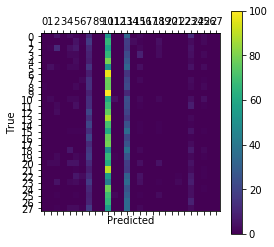

In [74]:
print_test_accuracy(test_input_encode,test_out_encode, True)

## Save the model

In [75]:
# path to save the model on the disk
model_name  = "two_d_cnn.ckpt"
save_path = "../models/{}".format(model_name)

In [76]:
# Saver
saver = tf.train.Saver()

In [77]:
# Saving the file
# saver.save(session,save_path)

## Plot the conv_layer and plot conv_weights

In [78]:
# Do this later, not so important, If the accuracy is low then use this

## Read back the model and test the segmented_objects

### Clear the tf session

In [79]:
tf.reset_default_graph()

In [80]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

x_image = tf.reshape(x,[-1, img_shape[0], img_shape[1], num_channels])

y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

y_true_cls = tf.argmax(y_true, axis=1)

layer_conv1, weights_conv1 = \
    new_conv_layer(input_layer= x_image,
                  num_input_channels=num_channels,
                  filter_size = filter_size1,
                  num_filters = num_filters1,
                  use_pooling=True)
layer_conv2, weights_conv2 = \
    new_conv_layer(input_layer=layer_conv1,
                  num_input_channels=num_filters1,
                  filter_size = filter_size2,
                  num_filters= num_filters2,
                   use_pooling=True)
layer_flat, num_features = flatten_layer(layer_conv2)
layer_fc1 = new_fc_layer(input_layer=layer_flat,
                        num_inputs= num_features,
                        num_outputs= fc_size,
                        use_relu=True)

layer_fc2 = new_fc_layer(input_layer=layer_fc1,
                        num_inputs = fc_size,
                        num_outputs= num_classes,
                        use_relu= False)
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, axis=1)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                       labels=y_true)

cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

correct_prediction = tf.equal(y_pred_cls, y_true_cls)

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Restore the Model

In [81]:
#Creating the new saver
new_saver = tf.train.Saver()

# Creating a tensor session
session = tf.Session()

# Running the session
session.run(tf.global_variables_initializer())

# restoring the model
new_saver.restore(session, save_path)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../models/two_d_cnn.ckpt


Accuracy on Test-Set: 84.7% (2845 / 3360)
Confusion Matrix:
[[109   0   0   0   1   0   0   3   0   0   0   0   0   1   0   0   0   0
    1   0   0   1   0   0   0   4   0   0]
 [  0 116   0   0   0   0   0   0   0   0   0   0   2   0   0   0   1   0
    0   0   0   1   0   0   0   0   0   0]
 [  0   0 114   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0
    0   0   3   0   2   0   0   0   0   0]
 [  0   0  11  79   0   0   0   0   0   0   2   0   0   0   0   3   0   0
    0   0   1   0   9  11   0   4   0   0]
 [  1   0   0   0 100   0   0   0   0   0   6   0   0   0   0   0   0   1
    0   0   0   5   0   1   0   6   0   0]
 [  0   0   0   0   0 116   0   0   0   0   0   0   0   0   0   0   0   0
    4   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  91   0   0  17   0   0   0   6   0   0   0   4
    0   2   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   7  79   2   1   0   0   8   6   0   0   0   6
    0   2   0   0   0   0   9   0   0   0]
 [  

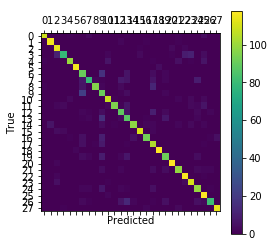

In [82]:
# testing the model again
print_test_accuracy(test_input_encode,test_out_encode, True)

### Remove the outliers and Segment the scene

### Fix the input for each scene and predict

### Convert the prediction into objects and count

## Function to calculate Accuracy, Precision, Recall, Total Run time and Latency

```
Runtime and Latency:

Total runtime (rank_0): The time span between receiving the first scene from the input queue and submitting the classification results for the last scene. The lower the total runtime measure the higher the position in the ranking. 

Latency is (rank_1) measured as the average time span between retrieving a scene from the input queue and providing a classification for the scene averaged across all scenes n. The lower the latency the higher the position in the ranking.

Accuracy, Precision and Recall:

Accuracy (rank_2) for each scene is defined as the proportion of the correctly predicted objects in the scene to the total number of predicted Yi and existing Zi objects in the scene. The accuracy is averaged across all scenes n:
```
<img src="http://www.debs2019.org/img/GC_accuracy.png" alt="Kitten"
	title="A cute kitten" width="300" height="200" />

```
Precision (rank_3) is the proportion of correctly predicted objects to the total number of existing objects in the scene, averaged over all scenes n:
```
<img src="http://www.debs2019.org/img/GC_precision.png" alt="Kitten"
	title="A cute kitten" width="300" height="200" />

 ```
Recall (rank_4) is the proportion of correctly predicted objects to the total number of predicted objects Yi in the scene, averaged over all scenes n:
```
<img src="http://www.debs2019.org/img/GC_recall.png" alt="Kitten"
	title="A cute kitten" width="300" height="200" />
 